Notebook to compute visual explainability results of the models prediction and to derive forecasted event positions estimations

# Libraries

In [1]:
from config import*

import numpy as np
import pandas as pd
from scipy import ndimage
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

from sundl.utils.data import read_Dataframe_With_Dates

2024-01-23 14:05:44.015607: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Setup

In [2]:
FOLDER    = PATH_RES/'Results_Paper_PCNN' 
modelName = 'C+_mpf_PTx8_RtdXall_ProgPos_AW1e5D1e4_0193x0211x0094_24'

date      = pd.to_datetime('17-02-2023 10:00:00')

labelCol = modelName.split('_')[1]
h = modelName.split('_')[-1]

/var/folders/2f/7x2b25l505v3y0t1yrc6rybm0000gn/T/ipykernel_67131/3719465047.py:4: UserWarning: Parsing dates in %d-%m-%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  date      = pd.to_datetime('17-02-2023 10:00:00')


# Explainability

## Load Image and Pred Results

143.02688431658365 47.15161110127087
185.63893892430073 12.929210208512757
75.27045759825364 74.04808450416904
211.87129521341635 65.83713188630753


Text(0.5, 0.98, 'C+ SPCNN-EUV Forecasts against ground truth the 17-02-2023 at 10:00')

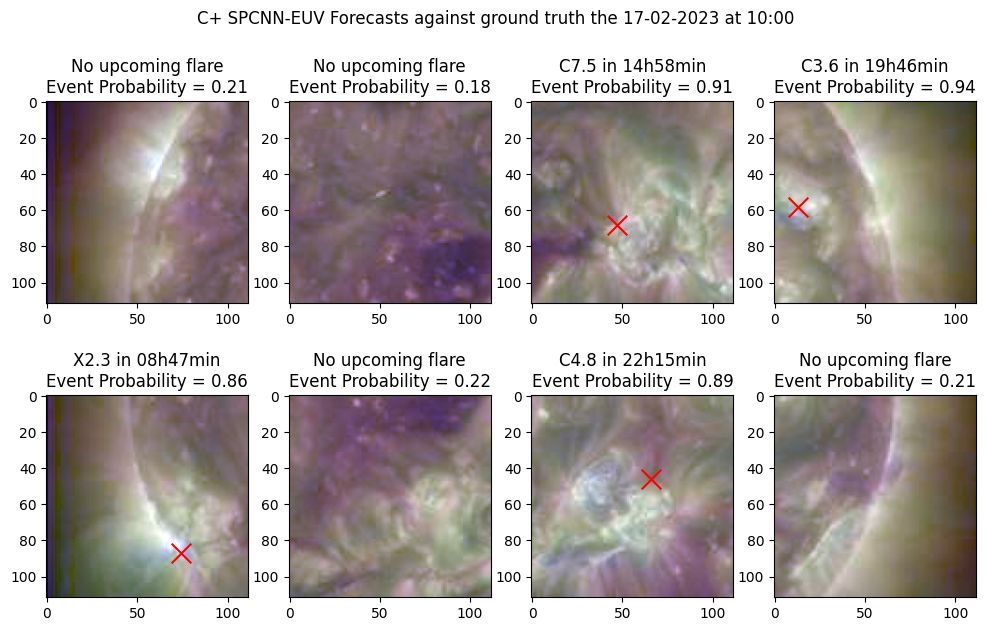

In [3]:
from sundl.utils.flare import flux2cls

rot_corr = True

# brightness and contrasst settings
red     = 1.09#1.15
green   = 1.1#0.9#.2
blue    = 1.22#2#.5#.5
normminmax = True # minmmax normalisation of the distribution
normpow = np.array([1.5,1.65,0.55]) #0.65 # pixel diistrib ttransformatio before minmax

preds = read_Dataframe_With_Dates(F_PATH_PREDS_MODEL(F_PATH_PREDS(FOLDER),modelName,'pt',True))
preds = preds[preds.index == date]

channel = modelName.split('_')[-2]
fn = date.strftime(f'%Y%m%d_%H%M_{channel}.jpg')
pathImage = PATH_IMAGES/f'{channel}/{date.year}/{date.month:0>2d}/{date.day:0>2d}/{fn}'

image_pil = np.array(tf.keras.utils.load_img(pathImage)).astype('float64')

if normminmax :
  for chIdx in range(3):
    if normpow is not None:
      image_pil[:,:,chIdx] = np.power(image_pil[:,:,chIdx], normpow[chIdx])
    image_pil[:,:,chIdx] = 255 * (image_pil[:,:,chIdx] - image_pil[:,:,chIdx].min()) / (image_pil[:,:,chIdx].max() - image_pil[:,:,chIdx].min())
image_pil[:,:,0] = red * image_pil[:,:,0]
image_pil[:,:,1] = green * image_pil[:,:,1]
image_pil[:,:,2] = blue * image_pil[:,:,2]
image_pil[image_pil>255] = 255
image_pil = image_pil.astype('uint8')

patches_size = (112,112)
image = tf.convert_to_tensor(image_pil)
image = tf.expand_dims(image_pil,0)
patches = tf.image.extract_patches(images=image,
                                   sizes   = [1, patches_size[0], patches_size[1], 1],
                                   strides = [1, patches_size[0], patches_size[1], 1],
                                   rates   = [1, 1, 1, 1],
                                   padding='VALID')


fig = plt.figure(figsize=(12, 7))
for imgs in patches:
    ptcID = 0
    for r in range(2):
        for c in range(4):
            ax = plt.subplot(2, 4, ptcID+1)
            # im = imgs[r,c].numpy()
            im = tf.reshape(imgs[r,c],shape=(112,112,3)).numpy().astype("uint8")
            plt.imshow(im)
            if preds[f'mpf_pt{ptcID}'].iloc[0] < 1e-6:
              title = 'No upcoming flare'
            else:
              t2f = preds[f't2f_pt{ptcID}'].iloc[0]
              min = 60*(t2f-int(t2f))
              mpf = preds[f'mpf_pt{ptcID}'].iloc[0]
              cls = flux2cls(mpf, detailed = True)
              im_size = 4096
              dwsF = im_size / 448
              mod = patches_size[0]
              x = preds[f'x_pt{ptcID}'].iloc[0]
              y = preds[f'y_pt{ptcID}'].iloc[0]

              # ROTATION CORRECATION
              if rot_corr:
                ylim = 614 / 0.6
                Rpix = 959.63 / 0.6
                ord = y - im_size //2
                if ord > 0:
                  ord = np.min((ord,ylim))
                else:
                  ord = np.max((ord,-ylim))
                y = ord
                ref = 2 * np.sqrt(Rpix**2 - ord**2) # ref = 2*Rpix
                half_carr = 27 * 24 / 2
                rot =  ref * t2f / half_carr
                x = x - rot


              x = x / dwsF % mod
              y = y / dwsF % mod


              print(rot, x)

              plt.scatter(x, y, marker="x", color="red", s=200)
              title = f'{cls} in {int(t2f):0>2d}h{min:0>2.0f}min'
            prob = preds[f'pred_pt{ptcID}'].iloc[0]
            title += f'\nEvent Probability = {prob:.2f}'
            ax.set_title(title)
            ptcID += 1
ts = date.strftime('%d-%m-%Y at %H:%M')
fig.suptitle(f'C+ SPCNN-EUV Forecasts against ground truth the {ts}')

# 62.79517657339716
# 33.23346915335816
# 82.28079080397804
# 89.01055480027497

/var/folders/2f/7x2b25l505v3y0t1yrc6rybm0000gn/T/ipykernel_67131/1212577282.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(im[:,:,0])


<Axes: ylabel='Density'>

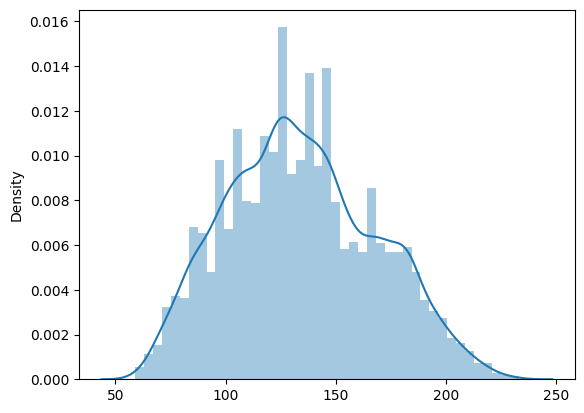

In [4]:
sns.distplot(im[:,:,0])

/var/folders/2f/7x2b25l505v3y0t1yrc6rybm0000gn/T/ipykernel_67131/3222709253.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(im[:,:,1])


<Axes: ylabel='Density'>

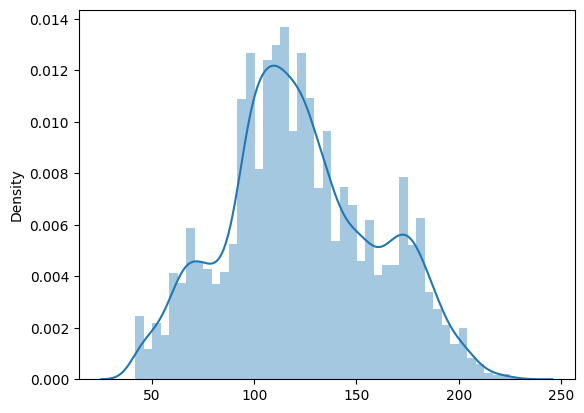

In [5]:
sns.distplot(im[:,:,1])

/var/folders/2f/7x2b25l505v3y0t1yrc6rybm0000gn/T/ipykernel_67131/2620641847.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(im[:,:,2])


<Axes: ylabel='Density'>

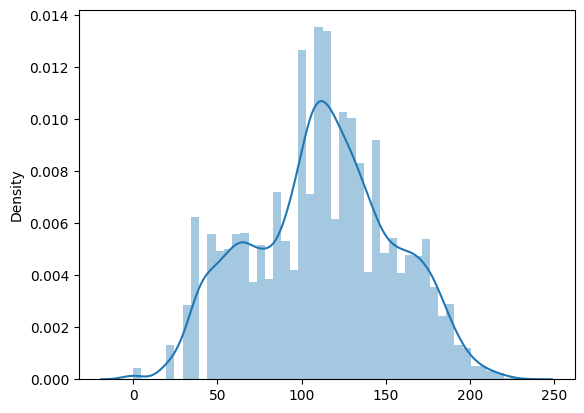

In [6]:
sns.distplot(im[:,:,2])

## Loading model and input

In [8]:
# # folderName  = 'Classification_02_24h_SC25_Paper_CV5_CV05_2023_11_06__0'
# # Classification_02_24h_SC25_Paper_CV5_CV05_2023_11_06__0
# # Classification_01_24h_Peak24_Paper_CV5_bt064xCV05_2023_11_03__0
# FOLDER  = pathRes/folderName
from pathlib import Path
from glob import glob
import datetime
import dill as pickle

from sundl.dataloader.sdocml import builDS_image_feature
from sundl.explainability import getDistributedModel


pathTestSamples = F_PATH_TEST(labelCol, h)


dfTest = pd.read_csv(pathTestSamples)
dfTest['timestamp'] = dfTest['timestamp'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S')) # '%Y/%m/%d/H%H00/
dfTest = dfTest.set_index('timestamp',drop = True)

samples = dfTest[(dfTest.index >= date + pd.DateOffset(hours = 24)) & (dfTest.index < date + pd.DateOffset(hours = 24 + 2))].copy()

modelsConfigAndPath = glob((FOLDER/f'models/{modelName}*').as_posix())
modelFoldsPath = [m for m in modelsConfigAndPath if m[-3:]!='pkl']
modelFoldsConfigs = [m for m in modelsConfigAndPath if m[-3:]=='pkl']
foldIds = [m[-5:] for m in modelFoldsPath]
num_fold = len(foldIds)

for foldIdx in range(num_fold-1,-1,-1):
  if not Path(f'{modelFoldsPath[foldIdx]}/assets').exists():
    modelFoldsPath.pop(foldIdx)
    modelFoldsConfigs.pop(foldIdx)
    foldIds.pop(foldIdx)
print('FOLDS WITH MODELS: ',foldIds)

with open(modelFoldsConfigs[0], 'rb') as f1:
  config = pickle.load(f1)
configTest = config['dataset_val']
configTest['dfTimeseries'] = dfTest#[dfTest.index.isin(preds.index+pd.offsets.DateOffset(hours=24))].copy()

# configTest['dfTimeseries'] = configTest['dfId2History']
# configTest.pop('dfId2History')
configTest['pathDir'] = PATH_IMAGES
configTest['samples'] = samples
configTest['cache'] = False
configTest['shuffle'] = False
configTest['weightByClass'] = False
configTest['batch_size'] = 1
# PROBEM WITH SAVED ENCODER -> RRREINSTATINT IT**
classTresholds = configTest['classTresholds']
binCls = modelName[0]
configTest['labelEncoder'] = lambda flux : float(flux >= classTresholds[binCls][0])

dsTest , _, missing_file_regexp, dfSamples_corr = builDS_image_feature(**configTest)
dfSamples_corr = dfSamples_corr.set_index('timestamp',drop = True)

# predictionss
predsFd = []
patch_predsFd = []
models = []
patchers = []
patcheModels = []
for foldIdx,modelFoldPath in enumerate(modelFoldsPath):
  models.append(tf.keras.models.load_model(modelFoldPath, compile=False))
  for layer in models[-1].layers:
    # print(layer.name)
    if layer.name == 'time_distributed':
      patchesBlock = layer
  patcheModels.append(tf.keras.Model(models[-1].input, patchesBlock.output, name='patches'))
  # predsFd.append(model.predict(dsTest))
  patchers.append(getDistributedModel(models[-1]))


FOLDS WITH MODELS:  ['fd000', 'fd001', 'fd003', 'fd004', 'fd002']
Samples shiiftng done
labelCol mpf
classTresholds {'quiet': (0.0, 1e-07), 'B': (1e-07, 1e-06), 'C': (1e-06, 1e-05), 'M': (1e-05, 0.0001), 'X': (0.0001, inf)}
img_size (224, 448, 3)
im.shape (224, 448, 3)
Num layers and num updated :  517 282
Num layers and num updated :  517 282
Num layers and num updated :  517 282
Num layers and num updated :  517 282
Num layers and num updated :  517 282


## Compute explainability

1/1 [==============================] - 0s 63ms/step
tf.Tensor(0, shape=(), dtype=int64)
1/1 [==============================] - 0s 67ms/step
tf.Tensor(0, shape=(), dtype=int64)
1/1 [==============================] - 0s 58ms/step
tf.Tensor(0, shape=(), dtype=int64)
1/1 [==============================] - 0s 60ms/step
tf.Tensor(0, shape=(), dtype=int64)
1/1 [==============================] - 0s 66ms/step
tf.Tensor(0, shape=(), dtype=int64)
1/1 [==============================] - 0s 56ms/step
tf.Tensor(0, shape=(), dtype=int64)
1/1 [==============================] - 0s 59ms/step
tf.Tensor(0, shape=(), dtype=int64)
1/1 [==============================] - 0s 53ms/step
tf.Tensor(0, shape=(), dtype=int64)
1/1 [==============================] - 0s 55ms/step
tf.Tensor(0, shape=(), dtype=int64)
1/1 [==============================] - 0s 59ms/step
tf.Tensor(0, shape=(), dtype=int64)
1/1 [==============================] - 0s 58ms/step
tf.Tensor(0, shape=(), dtype=int64)
1/1 [===========================

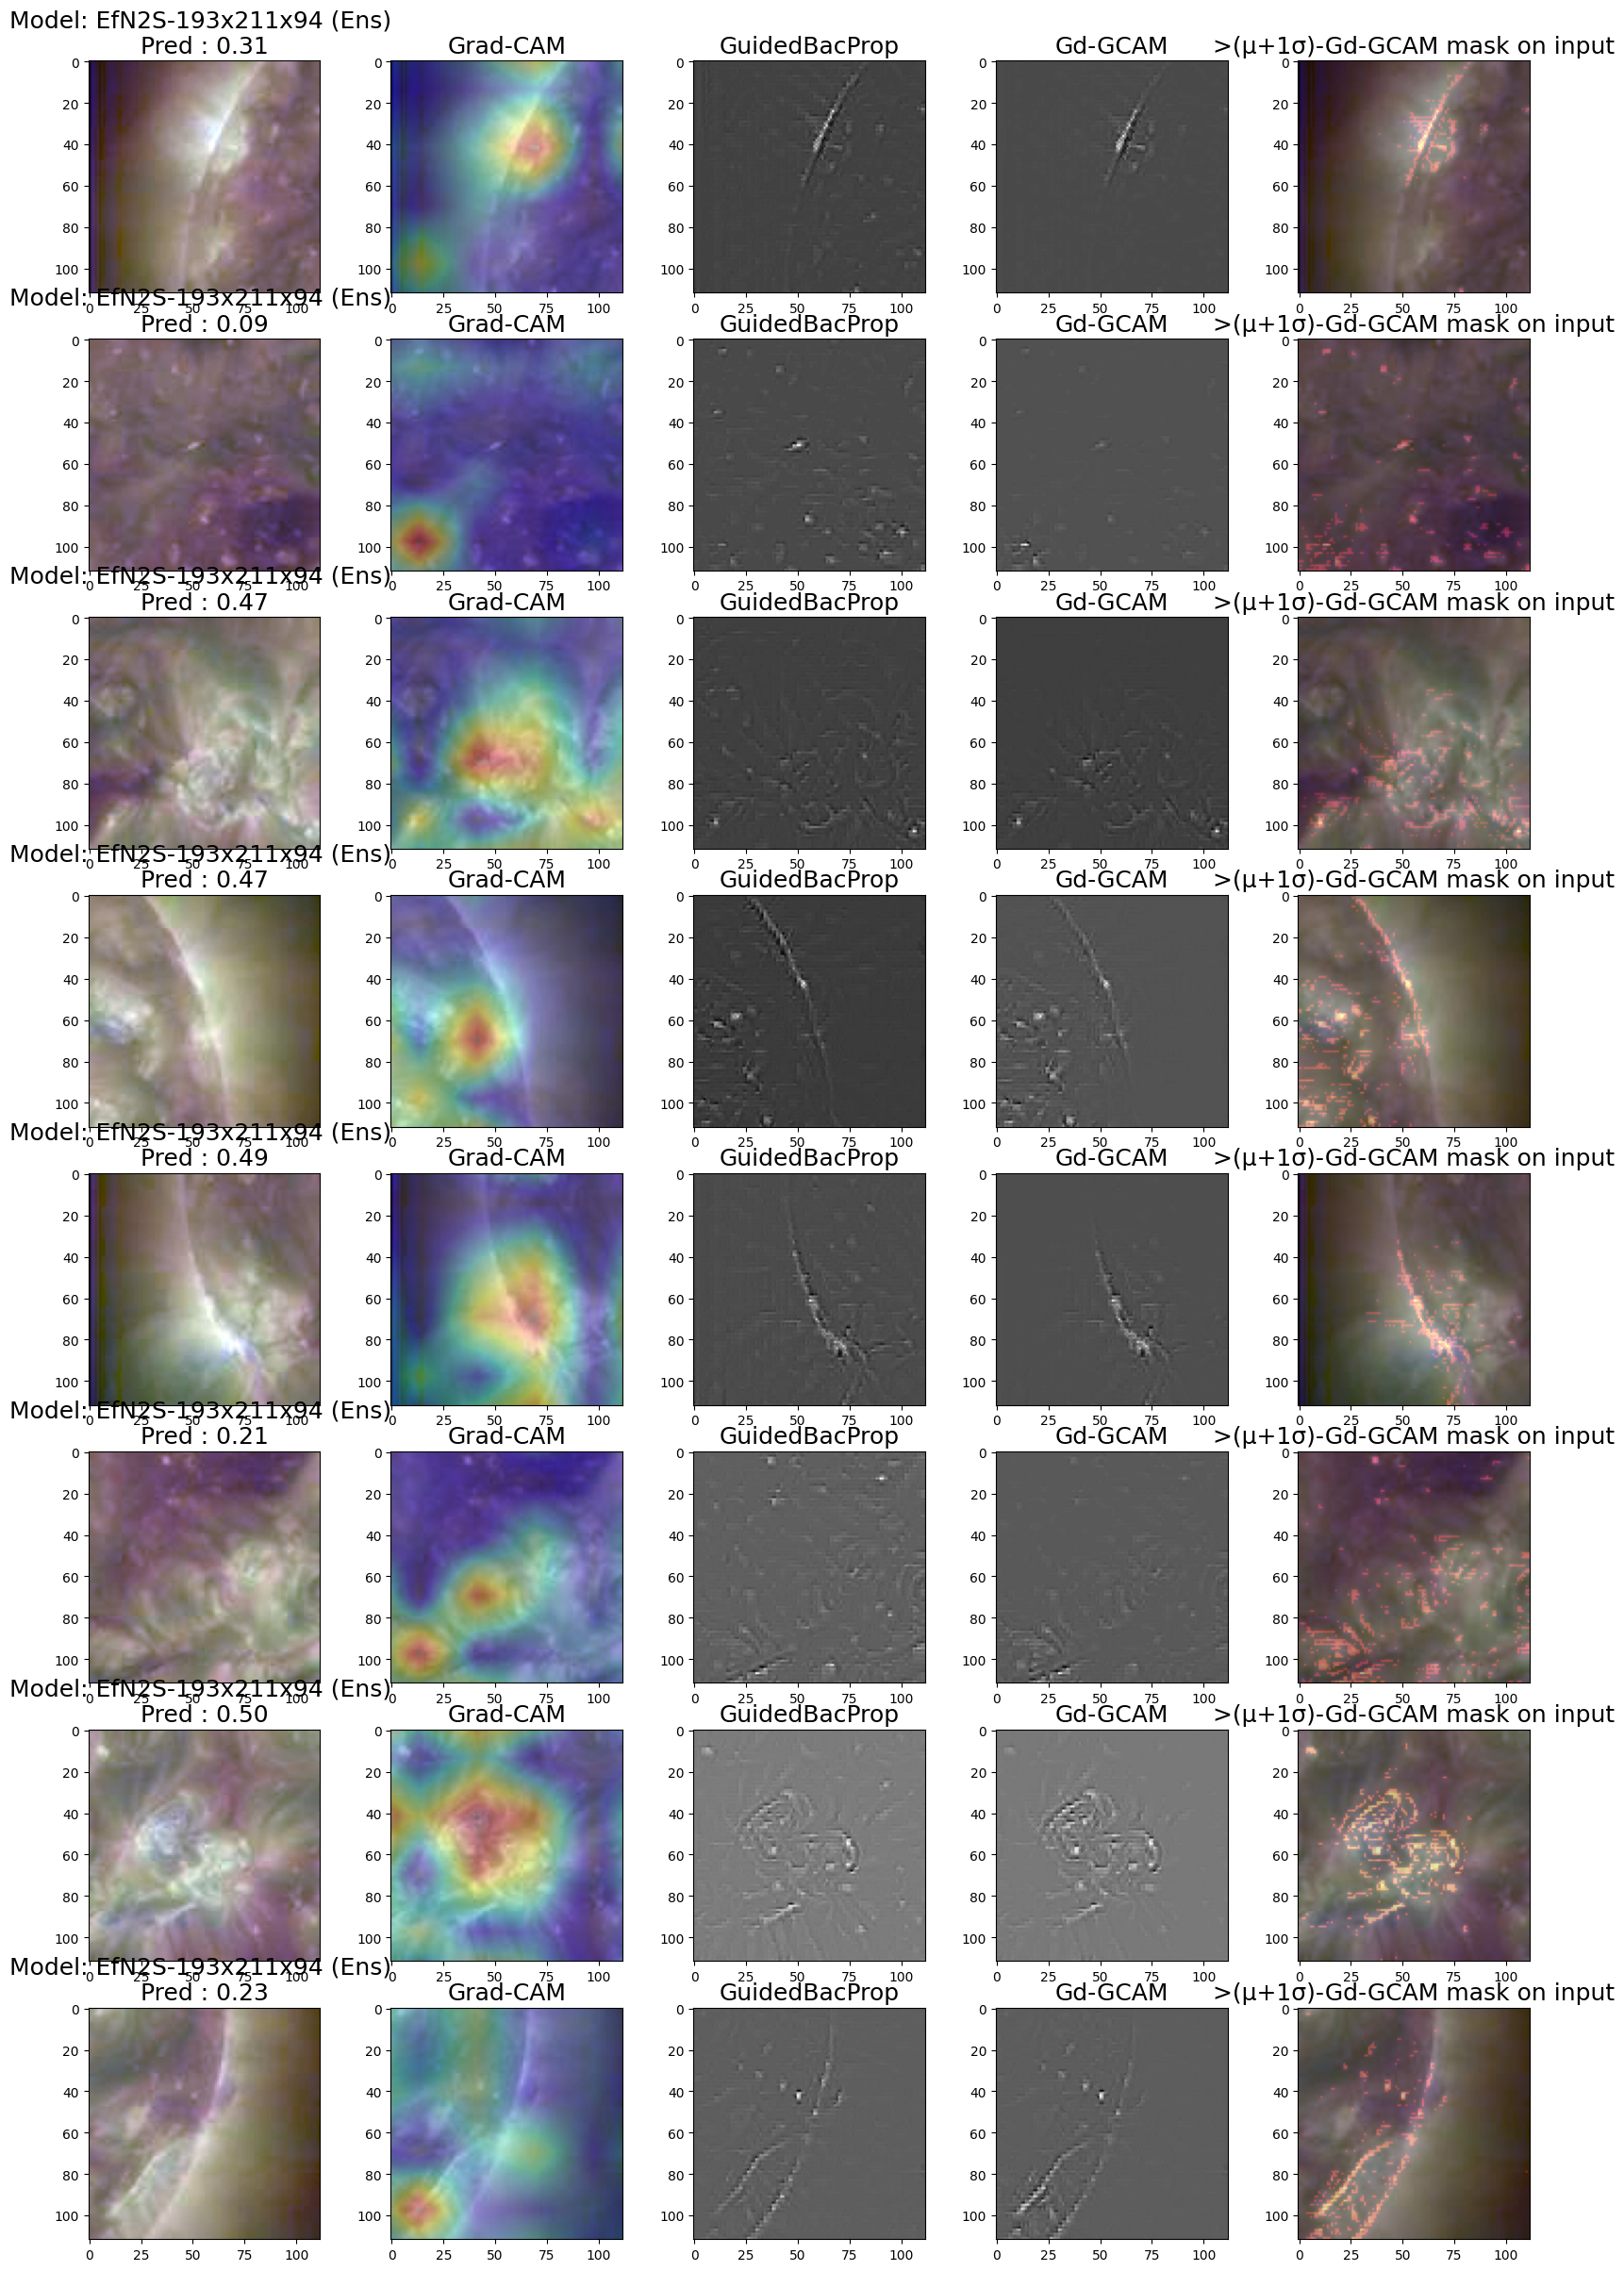

In [9]:
%%time
from sundl.explainability import EnsembleExplainabilityRGB

plt.rcParams["figure.figsize"] = (20,30)


# ptcIdx = 3

maskBp = False
fontsize = 18
alphaMask = 0.3
sigmaFact = 1

# patchesReady = [tf.expand_dims(patches[0,ptcIdx], axis = 0) for ptcIdx in range(patches.shape[1])]

patchesReady = [tf.expand_dims(tf.reshape(patches[0][r,c],shape=(112,112,3)).numpy().astype("uint8"), axis = 0) \
                for r in range(2) for c in range(4)]
fig, ax = plt.subplots(len(patchesReady),5)

predsCorona =  []
vizGcamEnsRes = []
vizGbEnsRes = []
vizGbGcamEnsRes = []

for ptcIdx in range(len(patchesReady)):
  predCorona, vizGcamEns, vizGbEns, vizGbGcamEns  = EnsembleExplainabilityRGB(
      ax              = ax,
      rowIdx          = ptcIdx,
      modName         = 'EfN2S-193x211x94 (Ens)',
      imgIdx          = None,
      alphaMask       = alphaMask,
      sigmaFact       = sigmaFact,
      images          = patchesReady[ptcIdx],
      ds              = None,
      models          = patchers,
      maskBp          = maskBp,
      bpCmam          = plt.get_cmap('binary').reversed(), # twilight_shifted ; twilight_shifted
      cmapMask        = 'hot',
      fontsize        = fontsize
      )
  predsCorona.append(predCorona)
  vizGcamEnsRes.append(vizGcamEns)
  vizGbEnsRes.append(vizGbEns)
  vizGbGcamEnsRes.append(vizGbGcamEns)

## Grad-CAM

143.02688431658365 47.15161110127087
185.63893892430073 12.929210208512757
75.27045759825364 74.04808450416904
211.87129521341635 65.83713188630753


Text(0.5, 0.98, 'C+ SPCNN-EUV Grad-CAM of Positive predictions the 17-02-2023 at 10:00')

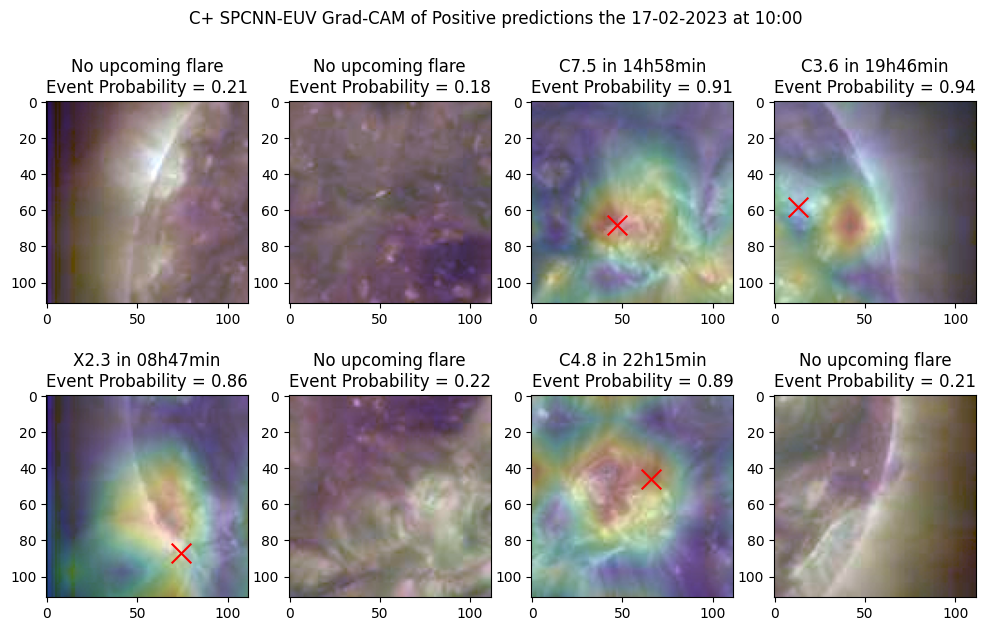

In [10]:
alphaMask = 0.2

rot_corr = True


fig = plt.figure(figsize=(12, 7))
for imgs in patches:
    ptcID = 0
    for r in range(2):
        for c in range(4):
            ax = plt.subplot(2, 4, ptcID+1)
            img = tf.reshape(imgs[r,c],shape=(112,112,3)).numpy().astype("uint8")
            plt.imshow(img)
            if preds[f'mpf_pt{ptcID}'].iloc[0] < 1e-6:
              title = 'No upcoming flare'
            else:
              # ***** explainability ******
              plt.imshow(vizGcamEnsRes[ptcID], alpha=alphaMask, cmap=plt.get_cmap('jet'))
              # ***************************
              t2f = preds[f't2f_pt{ptcID}'].iloc[0]
              min = 60*(t2f-int(t2f))
              mpf = preds[f'mpf_pt{ptcID}'].iloc[0]
              cls = flux2cls(mpf, detailed = True)
              im_size = 4096
              dwsF = im_size / 448
              mod = patches_size[0]
              x = preds[f'x_pt{ptcID}'].iloc[0]
              y = preds[f'y_pt{ptcID}'].iloc[0]

              # ROTATION CORRECATION
              if rot_corr:
                ylim = 614 / 0.6
                Rpix = 959.63 / 0.6
                ord = y - im_size //2
                if ord > 0:
                  ord = np.min((ord,ylim))
                else:
                  ord = np.max((ord,-ylim))
                y = ord
                ref = 2 * np.sqrt(Rpix**2 - ord**2) # ref = 2*Rpix
                half_carr = 27 * 24 / 2
                rot =  ref * t2f / half_carr
                x = x - rot


              x = x / dwsF % mod
              y = y / dwsF % mod


              print(rot, x)

              plt.scatter(x, y, marker="x", color="red", s=200)
              title = f'{cls} in {int(t2f):0>2d}h{min:0>2.0f}min'
            prob = preds[f'pred_pt{ptcID}'].iloc[0]
            title += f'\nEvent Probability = {prob:.2f}'
            ax.set_title(title)
            ptcID += 1
ts = date.strftime('%d-%m-%Y at %H:%M')
fig.suptitle(f'C+ SPCNN-EUV Grad-CAM of Positive predictions the {ts}')

## Guided-GCAM

143.02688431658365 47.15161110127087
185.63893892430073 12.929210208512757
75.27045759825364 74.04808450416904
211.87129521341635 65.83713188630753
CPU times: user 140 ms, sys: 6.75 ms, total: 147 ms
Wall time: 186 ms


Text(0.5, 0.98, 'C+ SPCNN-EUV Guided-GCAM of Positive predictions the 17-02-2023 at 10:00')

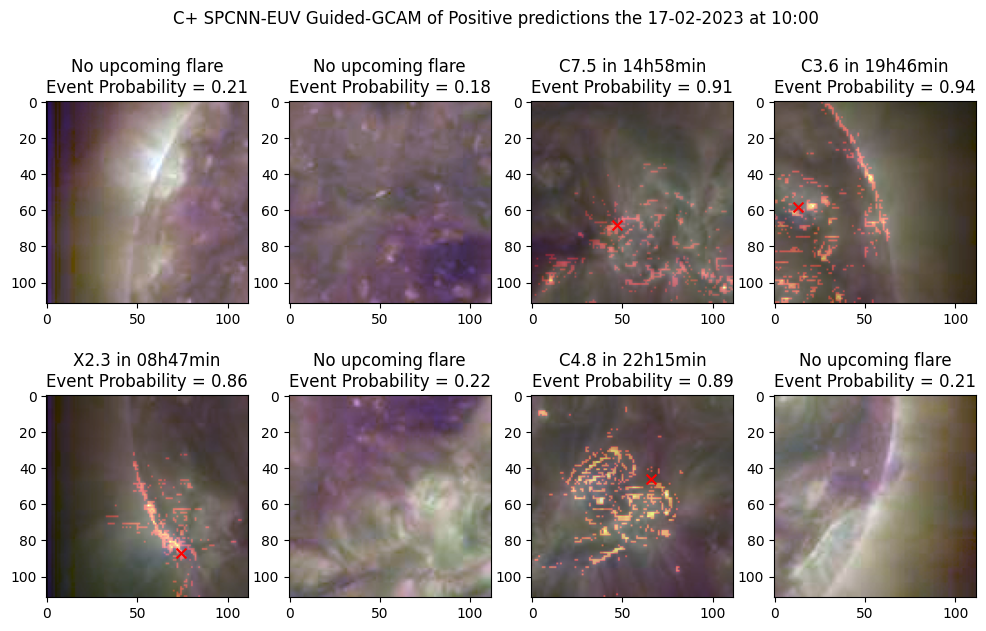

In [11]:
%%time
alphaMask = 0.4
sigmaFact = 1


rot_corr = True



fig = plt.figure(figsize=(12, 7))
for imgs in patches:
    ptcID = 0
    for r in range(2):
        for c in range(4):
            ax = plt.subplot(2, 4, ptcID+1)
            img = tf.reshape(imgs[r,c],shape=(112,112,3)).numpy().astype("uint8")
            plt.imshow(img)
            if preds[f'mpf_pt{ptcID}'].iloc[0] < 1e-6:
              title = 'No upcoming flare'
            else:
              # ***** explainability ******
              mask = vizGbGcamEnsRes[ptcID].copy()
              mean = mask.mean()
              sigma = mask.std()
              min =  mean - sigma * sigmaFact #0.3
              max =  mean + sigma * sigmaFact  #0.4
              mask[(mask<max)] = 0
              # vizGbGcamEns = np.mean(vizGbGcamEns, axis = -1)
              # vizGbGcamEns = ( vizGbGcamEns - vizGbGcamEns.min()) / (vizGbGcamEns.max() - vizGbGcamEns.min()) #255*
              plt.imshow(mask, alpha=alphaMask, cmap=plt.get_cmap('hot'))
              # ***************************
              t2f = preds[f't2f_pt{ptcID}'].iloc[0]
              min = 60*(t2f-int(t2f))
              mpf = preds[f'mpf_pt{ptcID}'].iloc[0]
              cls = flux2cls(mpf, detailed = True)
              im_size = 4096
              dwsF = im_size / 448
              mod = patches_size[0]
              x = preds[f'x_pt{ptcID}'].iloc[0]
              y = preds[f'y_pt{ptcID}'].iloc[0]

              # ROTATION CORRECATION
              if rot_corr:
                ylim = 614 / 0.6
                Rpix = 959.63 / 0.6
                ord = y - im_size //2
                if ord > 0:
                  ord = np.min((ord,ylim))
                else:
                  ord = np.max((ord,-ylim))
                y = ord
                ref = 2 * np.sqrt(Rpix**2 - ord**2) # ref = 2*Rpix
                half_carr = 27 * 24 / 2
                rot =  ref * t2f / half_carr
                x = x - rot


              x = x / dwsF % mod
              y = y / dwsF % mod


              print(rot, x)

              plt.scatter(x, y, marker="x", color="red", s=50)
              title = f'{cls} in {int(t2f):0>2d}h{min:0>2.0f}min'
            prob = preds[f'pred_pt{ptcID}'].iloc[0]
            title += f'\nEvent Probability = {prob:.2f}'
            ax.set_title(title)
            ptcID += 1
ts = date.strftime('%d-%m-%Y at %H:%M')
fig.suptitle(f'C+ SPCNN-EUV Guided-GCAM of Positive predictions the {ts}')

## Positions Estimations

143.02688431658365 47.15161110127087
185.63893892430073 12.929210208512757
75.27045759825364 74.04808450416904
211.87129521341635 65.83713188630753


/var/folders/2f/7x2b25l505v3y0t1yrc6rybm0000gn/T/ipykernel_67131/910053202.py:34: DeprecationWarning: Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  pos_est = ndimage.measurements.center_of_mass(explainability)


Text(0.5, 0.98, 'C+ SPCNN-EUV Forecast and Position estimations against ground truth the 17-02-2023 at 10:00')

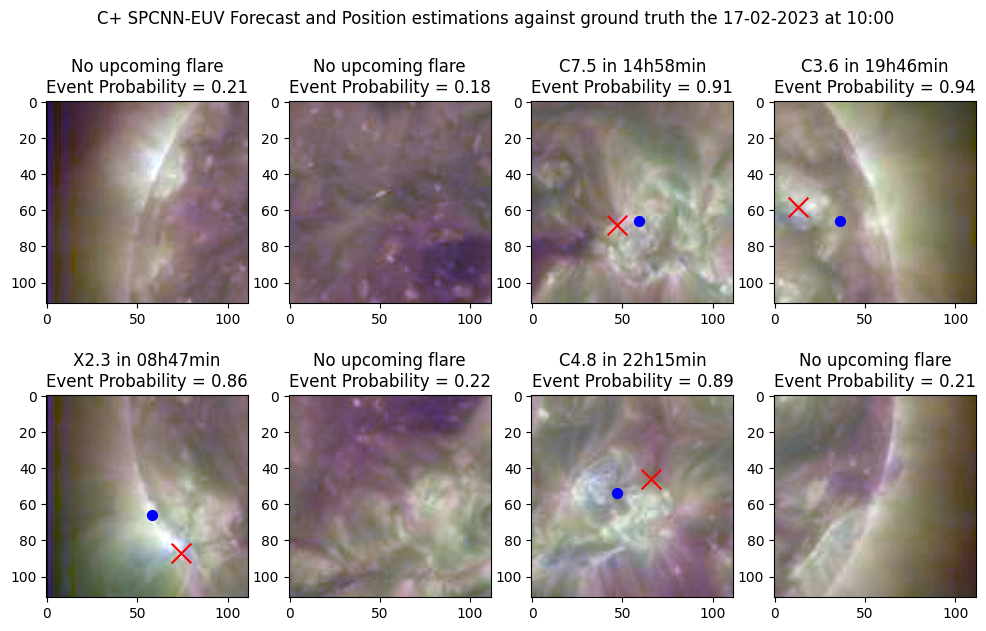

In [12]:
alphaMask = 0.2

explainType = 'gcam' # 'gcam', 'gbgcam
sigmaFact = 1

rot_corr = True



fig = plt.figure(figsize=(12, 7))
for imgs in patches:
    ptcID = 0
    for r in range(2):
        for c in range(4):
            ax = plt.subplot(2, 4, ptcID+1)
            img = tf.reshape(imgs[r,c],shape=(112,112,3)).numpy().astype("uint8")
            plt.imshow(img)
            if preds[f'mpf_pt{ptcID}'].iloc[0] < 1e-6:
              title = 'No upcoming flare'
            else:
              # ***** explainability ******
              # plt.imshow(vizGcamEnsRes[ptcID], alpha=alphaMask, cmap=plt.get_cmap('jet'))
              if explainType == 'gcam':
                explainability = vizGcamEnsRes[ptcID].copy()
              else:
                mask = vizGbGcamEnsRes[ptcID].copy()
                mean = mask.mean()
                sigma = mask.std()
                min =  mean - sigma * sigmaFact #0.3
                max =  mean + sigma * sigmaFact  #0.4
                mask[(mask<max)] = 0
                explainability = mask

              pos_est = ndimage.measurements.center_of_mass(explainability)
              x_est, y_est = int(round(pos_est[0])), int(round(pos_est[1]))
              # ***************************
              t2f = preds[f't2f_pt{ptcID}'].iloc[0]
              min = 60*(t2f-int(t2f))
              mpf = preds[f'mpf_pt{ptcID}'].iloc[0]
              cls = flux2cls(mpf, detailed = True)
              im_size = 4096
              dwsF = im_size / 448
              mod = patches_size[0]
              x = preds[f'x_pt{ptcID}'].iloc[0]
              y = preds[f'y_pt{ptcID}'].iloc[0]

              # ROTATION CORRECATION
              if rot_corr:
                ylim = 614 / 0.6
                Rpix = 959.63 / 0.6
                ord = y - im_size //2
                if ord > 0:
                  ord = np.min((ord,ylim))
                else:
                  ord = np.max((ord,-ylim))
                y = ord
                ref = 2 * np.sqrt(Rpix**2 - ord**2) # ref = 2*Rpix
                half_carr = 27 * 24 / 2
                rot =  ref * t2f / half_carr
                x = x - rot


              x = x / dwsF % mod
              y = y / dwsF % mod


              print(rot, x)

              plt.scatter(x, y, marker="x", color="red", s=200)
              plt.scatter(y_est, x_est, marker="o", color="blue", s=50)
              title = f'{cls} in {int(t2f):0>2d}h{min:0>2.0f}min'
            prob = preds[f'pred_pt{ptcID}'].iloc[0]
            title += f'\nEvent Probability = {prob:.2f}'
            ax.set_title(title)
            ptcID += 1
ts = date.strftime('%d-%m-%Y at %H:%M')
fig.suptitle(f'C+ SPCNN-EUV Forecast and Position estimations against ground truth the {ts}')